# Trabalho FINAL — Classificação de Revisões de Filmes
- Equipe: Pioneiros de Dados
## Analise dos dados - critic

## Instalação das Bibliotecas

In [1]:
!pip install catboost
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install wordcloud
!pip install matplotlib
import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes     import MultinomialNB
from sklearn.metrics         import accuracy_score ,balanced_accuracy_score
from sklearn.ensemble        import RandomForestClassifier

import nltk
from nltk.corpus import stopwords

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling  import RandomOverSampler
nlp = spacy.load('en_core_web_sm')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 44.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


#Acesso ao drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Funcoes

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

# Assuming y_test and y_pred_svc are already defined from previous code
# Example:
# y_test = ...  # True labels
# y_pred_svc = ... # Predicted labels

def plot_confusion_matrix_with_percentages(y_true, y_pred, title):
    # Ensure y_true and y_pred have the same length
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]

    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, cmap="Blues", annot=annot, fmt='', ax=ax)
    plt.title(title)
    plt.show()

## Carregar e preparar os dados

In [4]:

train_critic = pd.read_csv('/content/drive/My Drive/Classificação de Revisões de Filmes/train_critic.csv')
test_critic = pd.read_csv('/content/drive/My Drive/Classificação de Revisões de Filmes/test_critic.csv')
train_critic = train_critic[train_critic['Review'].notna() & train_critic['Review'].str.strip().astype(bool)]
test_critic  = test_critic[test_critic['Review'].notna() & test_critic['Review'].str.strip().astype(bool)]


# Mostrando 20 exemplos do review colorindo as palavras de acordo com a contribuicao dela para o sentiment

In [ ]:


import spacy
import pandas as pd
from IPython.display import HTML


nlp = spacy.load('en_core_web_sm')



def color_words(text, sentiment):
    doc = nlp(text)
    colored_text = ""
    for token in doc:
        if token.dep_ in ["nsubj", "ROOT", "dobj"]:  # Highlight key words
            if token.pos_ in ["ADJ", "VERB", "NOUN"]:
              if sentiment == 1: # Positive
                colored_text += f'<span style="color:green;">{token.text}</span> '
              else: #Negative
                colored_text += f'<span style="color:red;">{token.text}</span> '
            else:
              colored_text += f'{token.text} '
        else:
            colored_text += f'{token.text} '
    return colored_text

# Sample 20 reviews
sample_reviews = train_critic.sample(20)


# HTML
html_table = """<table>
    <tr>
        <th>Review</th>
        <th>Sentiment</th>
    </tr>"""

for index, row in sample_reviews.iterrows():
    colored_review = color_words(row['Review'], row['Sentiment'])
    html_table += f"""
    <tr>
        <td>{colored_review}</td>
        <td>{row['Sentiment']}</td>
    </tr>"""

html_table += "</table>"
display(HTML(html_table))

# Distribuicao das palavras da coluna Review em relacao a Sentiment (sem retirar stopwords)

<ipython-input-6-b6d207f190a9>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=positive_df, palette="Blues_d")
<ipython-input-6-b6d207f190a9>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=negative_df, palette="Reds_d")


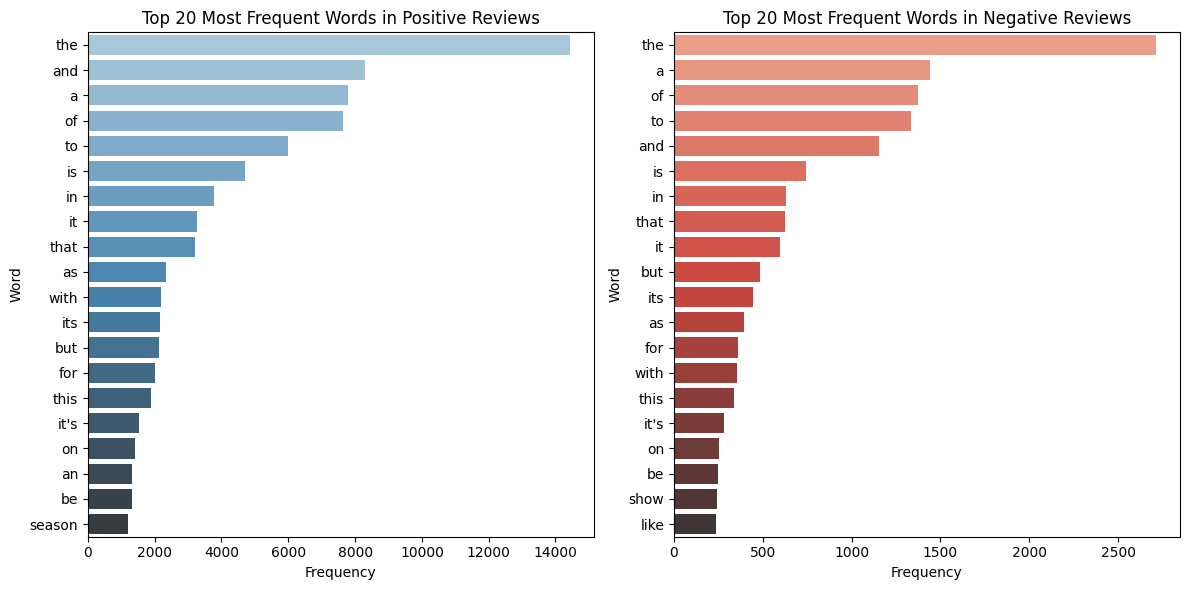

In [6]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter



def analyze_word_distribution(df):
    # Separate reviews by sentiment
    positive_reviews = df[df['Sentiment'] == 1]['Review'].str.cat(sep=' ')
    negative_reviews = df[df['Sentiment'] == 0]['Review'].str.cat(sep=' ')

    # Tokenize and count words for each sentiment
    positive_word_counts = Counter(positive_reviews.lower().split())
    negative_word_counts = Counter(negative_reviews.lower().split())

    # Get the top N frequent words (adjust N as needed)
    top_n = 20
    top_positive_words = positive_word_counts.most_common(top_n)
    top_negative_words = negative_word_counts.most_common(top_n)

    # Create DataFrames for plotting
    positive_df = pd.DataFrame(top_positive_words, columns=['Word', 'Frequency'])
    negative_df = pd.DataFrame(top_negative_words, columns=['Word', 'Frequency'])

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(x='Frequency', y='Word', data=positive_df, palette="Blues_d")
    plt.title('Top {} Most Frequent Words in Positive Reviews'.format(top_n))

    plt.subplot(1, 2, 2)
    sns.barplot(x='Frequency', y='Word', data=negative_df, palette="Reds_d")
    plt.title('Top {} Most Frequent Words in Negative Reviews'.format(top_n))

    plt.tight_layout()
    plt.show()


analyze_word_distribution(train_critic)

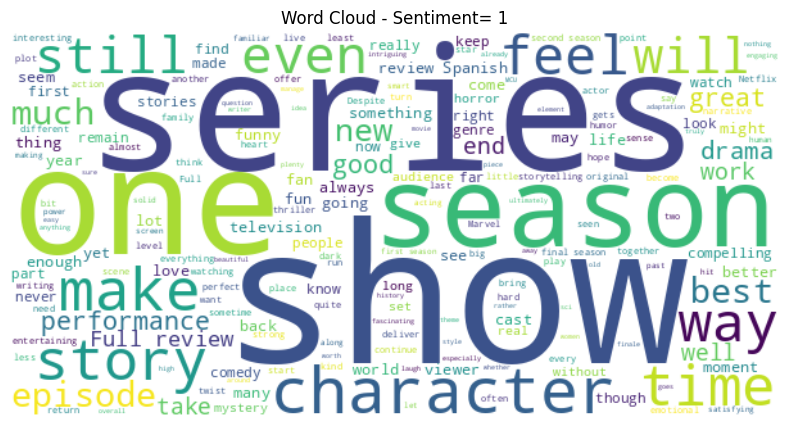

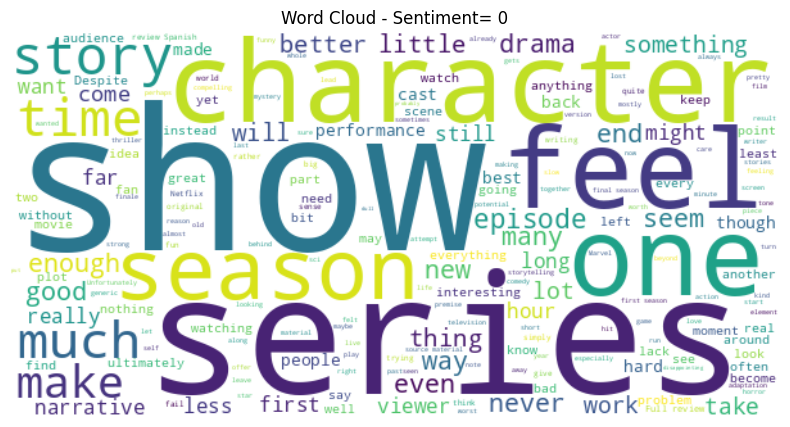

In [7]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_reviews = train_critic[train_critic['Sentiment'] == 1]['Review']
negative_reviews = train_critic[train_critic['Sentiment'] == 0]['Review']

# Generate word clouds
def generate_wordcloud(text, title):
    # Join the strings and generate the wordcloud
#    wordcloud = WordCloud(collocations = True,min_word_length=3,collocation_threshold=10, width=800, height=400, background_color='white').generate(" ".join(text)) # text is already a list of strings
    wordcloud = WordCloud(collocations = True,prefer_horizontal=1,min_word_length=3, width=600, height=300,contour_color='black', background_color='white').generate(" ".join(text)) # text is already a list of strings
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Generate and display word clouds for each sentiment
generate_wordcloud(positive_reviews.tolist(), "Word Cloud - Sentiment= 1") # Convert Series to list
generate_wordcloud(negative_reviews.tolist(), "Word Cloud - Sentiment= 0") # Convert Series to list

# trantando os textos
- RETIRANDO ACENTOS
- LEMATIZANDO
- PONTUACAO
- STOPWORDS

In [8]:
train_critic = pd.read_csv('/content/drive/My Drive/Classificação de Revisões de Filmes/train_critic.csv')
test_critic = pd.read_csv('/content/drive/My Drive/Classificação de Revisões de Filmes/test_critic.csv')
train_critic = train_critic[train_critic['Review'].notna() & train_critic['Review'].str.strip().astype(bool)]
test_critic  = test_critic[test_critic['Review'].notna() & test_critic['Review'].str.strip().astype(bool)]

train_critic['Review']= train_critic['Review'].apply(lambda x: x.lower())
test_critic['Review']= test_critic['Review'].apply(lambda x: x.lower())


from nltk.stem import PorterStemmer
nltk.download('stopwords')

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))  # Adjust for your language
def remove_stop_words(text):
    words = text.split()
    words = [word for word in words if word not in stop_words]
    #words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

train_critic['Review'] = train_critic['Review'].apply(remove_stop_words)
test_critic['Review'] = test_critic['Review'].apply(remove_stop_words)


# REMOVENDO palavras q aparecem nas em destaque nas duas classes, pontuacao, aspas e apostrofos.
import re
def clean_text(text):
    #text = re.sub(r'\bseries\b', '', text, flags=re.IGNORECASE)
    #text = re.sub(r'\bcome\b', '', text, flags=re.IGNORECASE)
    #text = re.sub(r'\blot\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\bs\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    text = re.sub(r'[àáâãäå]', 'a', text)
    text = re.sub(r'[èéêë]', 'e', text)
    text = re.sub(r'[ìíîï]', 'i', text)
    text = re.sub(r'[òóôõö]', 'o', text)
    text = re.sub(r'[ùúûü]', 'u', text)
    text = re.sub(r'[ç]', 'c', text)
    text = re.sub(r'[’]', '', text) #remove apostrophe
    text = re.sub(r'[""]', '', text) #remove quotation marks
    return text

train_critic['Review'] = train_critic['Review'].apply(clean_text)
test_critic['Review'] = test_critic['Review'].apply(clean_text)

# Funçoes
def apply_stemming(text):
    tokens = word_tokenize(text)
    stemmed = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed)
def apply_lemmatization(text):
    doc = nlp(text)
    lemmatized = [token.lemma_ for token in doc]
    return ' '.join(lemmatized)

# Aplicar as transformações na coluna Review
#train_critic['Review'] = train_critic['Review'].dropna().apply(apply_stemming)
train_critic['Review'] = train_critic['Review'].dropna().apply(apply_lemmatization)

#test_critic['Review'] = test_critic['Review'].dropna().apply(apply_stemming)
test_critic['Review'] = test_critic['Review'].dropna().apply(apply_lemmatization)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<ipython-input-6-b6d207f190a9>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=positive_df, palette="Blues_d")
<ipython-input-6-b6d207f190a9>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=negative_df, palette="Reds_d")


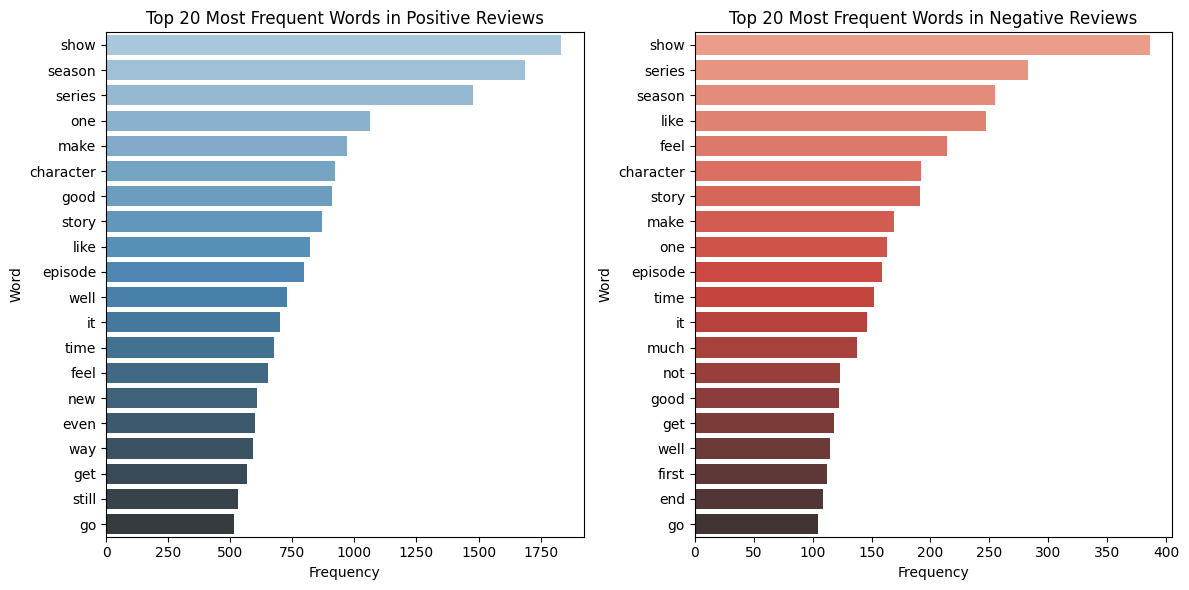

In [9]:
analyze_word_distribution(train_critic)

# barras comparando as palavras nas series sentiment (ordenado pelos positivos)

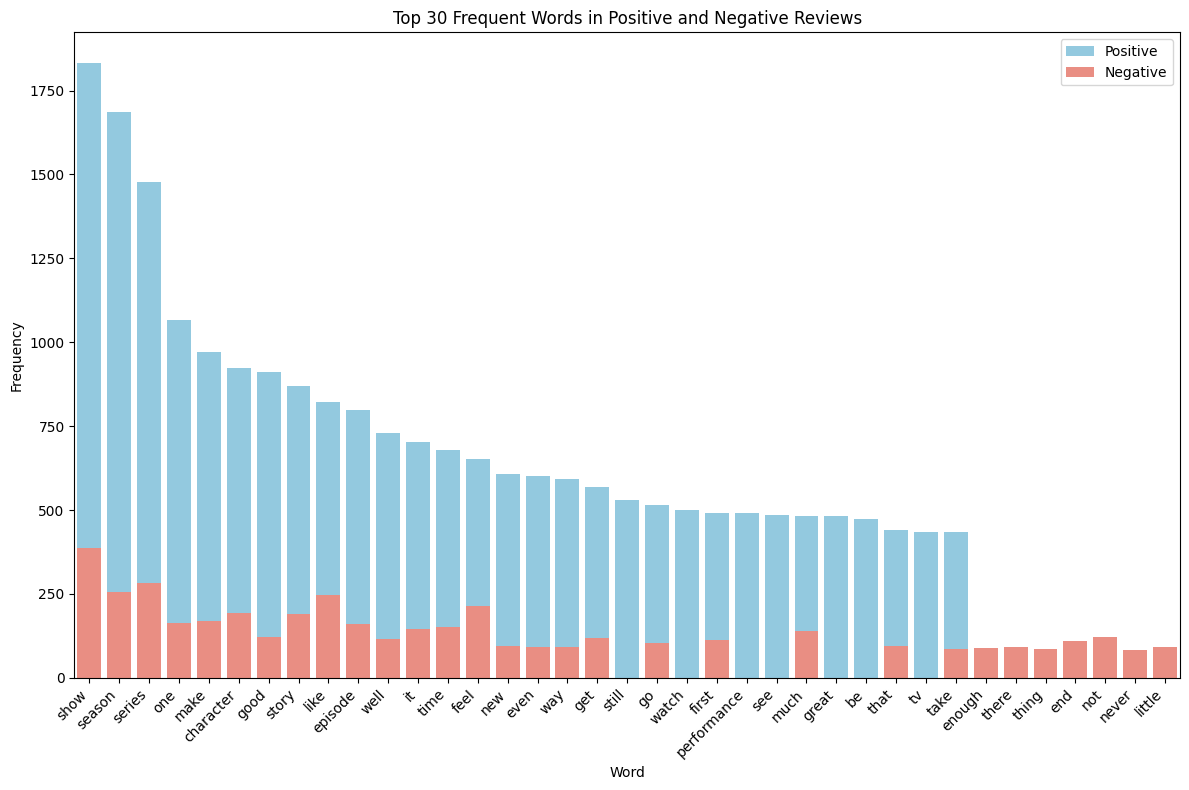

In [24]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def analyze_word_distribution(df):
    # Separate reviews by sentiment
    positive_reviews = df[df['Sentiment'] == 1]['Review'].str.cat(sep=' ')
    negative_reviews = df[df['Sentiment'] == 0]['Review'].str.cat(sep=' ')

    # Tokenize and count words for each sentiment
    from collections import Counter
    positive_word_counts = Counter(positive_reviews.lower().split())
    negative_word_counts = Counter(negative_reviews.lower().split())

    # Get the top N frequent words (adjust N as needed)
    top_n = 30
    top_positive_words = positive_word_counts.most_common(top_n)
    top_negative_words = negative_word_counts.most_common(top_n)

    # Create DataFrames for plotting
    positive_df = pd.DataFrame(top_positive_words, columns=['Word', 'Positive Frequency'])
    negative_df = pd.DataFrame(top_negative_words, columns=['Word', 'Negative Frequency'])

    # Merge the dataframes
    merged_df = pd.merge(positive_df, negative_df, on='Word', how='outer').fillna(0)

    # Plotting
    plt.figure(figsize=(12, 8))
    merged_df = merged_df.sort_values(by=['Positive Frequency'], ascending=False)
    sns.barplot(x='Word', y='Positive Frequency', data=merged_df, color="skyblue", label="Positive")
    sns.barplot(x='Word', y='Negative Frequency', data=merged_df, color="salmon", label="Negative")
    plt.title(f'Top {top_n} Frequent Words in Positive and Negative Reviews')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

analyze_word_distribution(train_critic)

# barras comparando as palavras nas series sentiment (ordenado pelos negativos)

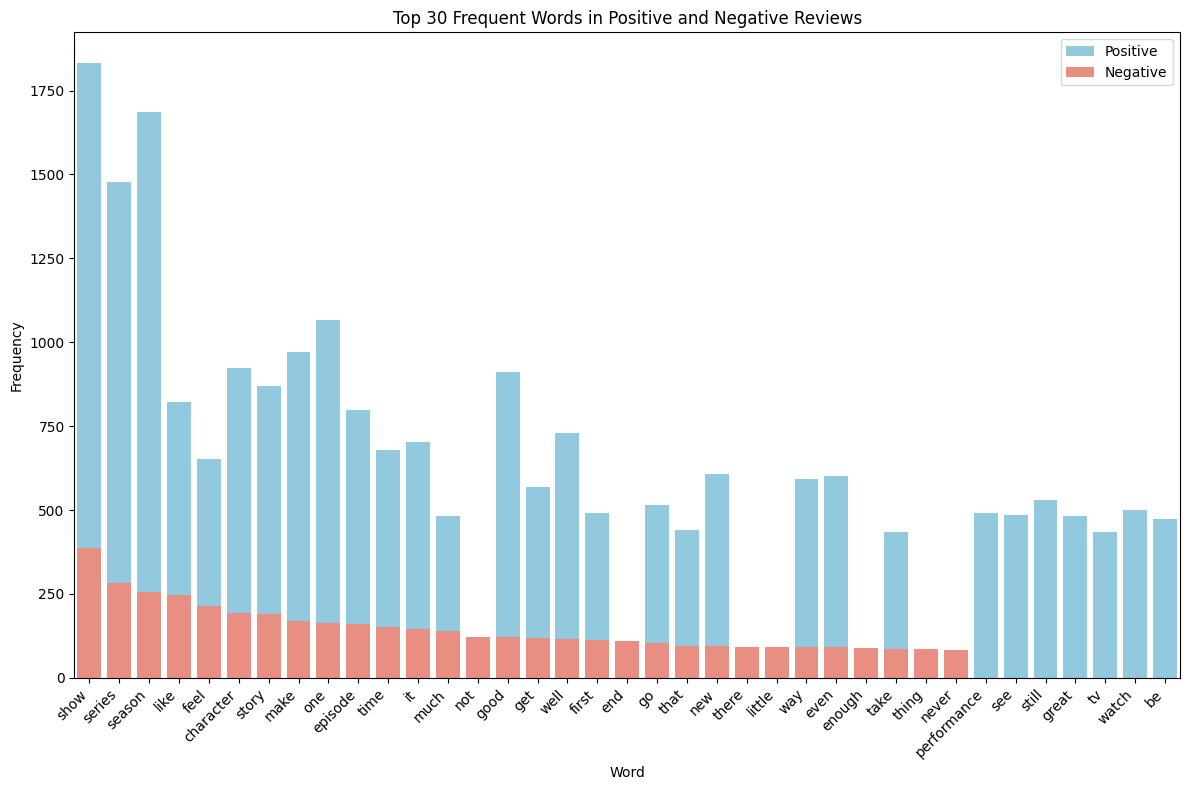

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def analyze_word_distribution(df):
    # Separate reviews by sentiment
    positive_reviews = df[df['Sentiment'] == 1]['Review'].str.cat(sep=' ')
    negative_reviews = df[df['Sentiment'] == 0]['Review'].str.cat(sep=' ')

    # Tokenize and count words for each sentiment
    from collections import Counter
    positive_word_counts = Counter(positive_reviews.lower().split())
    negative_word_counts = Counter(negative_reviews.lower().split())

    # Get the top N frequent words (adjust N as needed)
    top_n = 30
    top_positive_words = positive_word_counts.most_common(top_n)
    top_negative_words = negative_word_counts.most_common(top_n)

    # Create DataFrames for plotting
    positive_df = pd.DataFrame(top_positive_words, columns=['Word', 'Positive Frequency'])
    negative_df = pd.DataFrame(top_negative_words, columns=['Word', 'Negative Frequency'])

    # Merge the dataframes
    merged_df = pd.merge(positive_df, negative_df, on='Word', how='outer').fillna(0)

    # Plotting
    plt.figure(figsize=(12, 8))
    merged_df = merged_df.sort_values(by=['Negative Frequency'], ascending=False)
    sns.barplot(x='Word', y='Positive Frequency', data=merged_df, color="skyblue", label="Positive")
    sns.barplot(x='Word', y='Negative Frequency', data=merged_df, color="salmon", label="Negative")
    plt.title(f'Top {top_n} Frequent Words in Positive and Negative Reviews')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

analyze_word_distribution(train_critic)

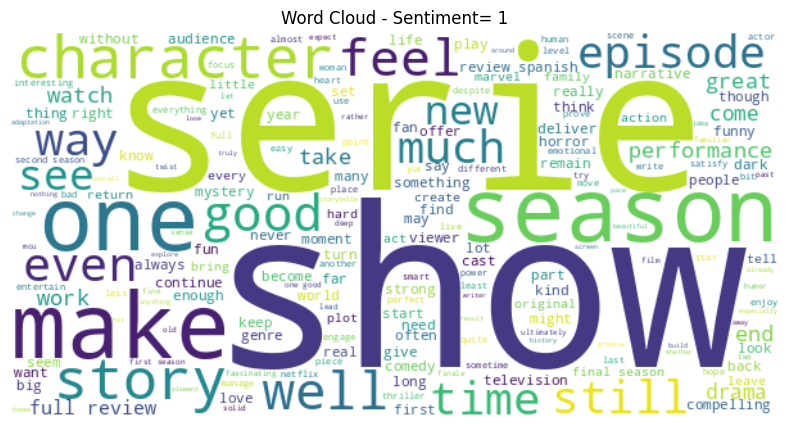

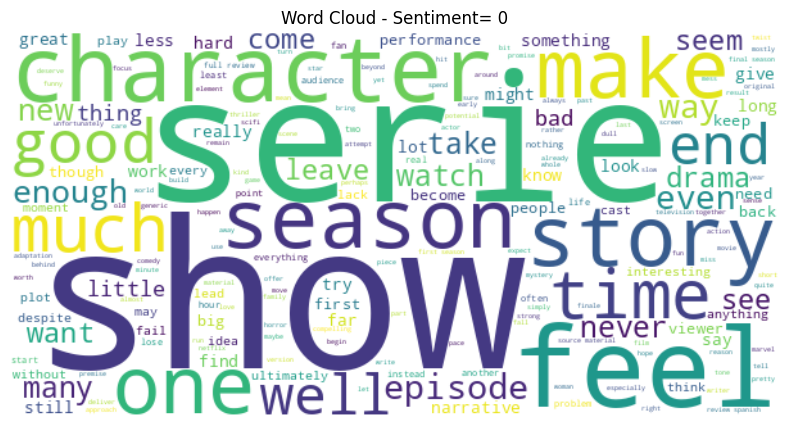

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_reviews = train_critic[train_critic['Sentiment'] == 1]['Review']
negative_reviews = train_critic[train_critic['Sentiment'] == 0]['Review']

# Generate word clouds
def generate_wordcloud(text, title):
    # Join the strings and generate the wordcloud
#    wordcloud = WordCloud(collocations = True,min_word_length=3,collocation_threshold=10, width=800, height=400, background_color='white').generate(" ".join(text)) # text is already a list of strings
    wordcloud = WordCloud(collocations = True,prefer_horizontal=1,min_word_length=3, width=600, height=300,contour_color='black', background_color='white').generate(" ".join(text)) # text is already a list of strings
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Generate and display word clouds for each sentiment
generate_wordcloud(positive_reviews.tolist(), "Word Cloud - Sentiment= 1") # Convert Series to list
generate_wordcloud(negative_reviews.tolist(), "Word Cloud - Sentiment= 0") # Convert Series to list